# Imports

In [ ]:
!conda activate py37
!pip install music21

Traceback (most recent call last):
  File "/Users/lstrika/anaconda2/bin/conda", line 13, in <module>
    sys.exit(main())
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/cli/main.py", line 149, in main
    from ..exceptions import conda_exception_handler
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/exceptions.py", line 19, in <module>
    from ._vendor.auxlib.entity import EntityEncoder
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/entity.py", line 253, in <module>
    from .collection import AttrDict, frozendict, make_immutable
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/collection.py", line 10, in <module>
    from .compat import isiterable, iteritems, odict, text_type
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/compat.py", line 10, in <module>
    from ._vendor.five import WhateverIO as StringIO, with_metaclass
  File "/Users/lstrik

In [1]:
from music21 import *
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

# Config variables

In [3]:
path = "gwern/midis"
frequent_notes_threshold = 50

n_of_timesteps = 32
evaluation_percentage = 0.2 # 20% of the data will be used as evaluation

output_dimension = 100
kernel_size = 3
epochs = 50

len_of_predictions = 30

# Aux functions

In [4]:
def read_midi(file):
    
    print("Reading: " + file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    try:
        midi = converter.parse(file)
    except:
        return np.array([])
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    if not s2:
        return np.array([])
    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [5]:
def convert_to_midi(prediction_output, filename):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    

# Core code

## Read files

In [6]:
from glob import glob
from multiprocess import Pool
import time


TRAINING_SET_SIZE = 1024
NTHREADS = 32

files = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.mid'))]
print(len(files))
start = time.time()
#files=[i for i in os.listdir(path) if i.endswith(".mid")]
with Pool(NTHREADS) as p:
    notes_array = p.map(read_midi, files[:TRAINING_SET_SIZE])

print('filtering...')
notes_array = [e for e in notes_array if e != np.array([])]

notes_array = np.array(notes_array, dtype=object)
print('notes...')
notes_ = [element for note_ in notes_array for element in note_]
end = time.time()

print(f'took {end - start} seconds')

77152
Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/fa09fc4cc12b6f2d085ecb98650d2de6.midReading: gwern/midis/lmd_matched/R/R/I/TRRRION128F145EBB7/9048c4045d7d8b2837f3725d7995dc1c.midReading: gwern/midis/lmd_matched/R/R/I/TRRRILO128F422FFED/0ec315d7be357f130de5206e67c33b36.midReading: gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03a193c336e18e86b5d845f34.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ef6b163c2a5d18dbffa3b24aaf21419d.mid




Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/6a4b5d29cecc86c2078f93edc8866299.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=0, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ee79e6b07b5bd944a4571918cdee715b.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=2, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/9f9c81dd249087150c9eac829c0f7c89.mid
Reading: gwern/midis/lmd_matched/R/R/N/TRRRNPV128F42AAA55/b9dc31daae7e35deffae077a705e01e7.mid
Reading: gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/18e05979f4132614733c340185809dee.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=16, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=17, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=18, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=19, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/loc

filtering...
notes...
took 39.8263201713562 seconds


/var/folders/xy/dzytbyv51dd88zf00d9qj1100000gn/T/ipykernel_6522/2862025795.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  notes_array = [e for e in notes_array if e != np.array([])]
/var/folders/xy/dzytbyv51dd88zf00d9qj1100000gn/T/ipykernel_6522/2862025795.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  notes_array = [e for e in notes_array if e != np.array([])]


In [7]:
notes_array.shape

(5,)

In [8]:
np.array([t.shape for t in notes_array]).mean()

485.8

## Analyze data

In [9]:
unique_notes = list(set(notes_))
print(len(unique_notes))

145


(array([101.,  20.,  12.,   7.,   1.,   2.,   0.,   1.,   0.,   1.]),
 array([  1. ,  16.9,  32.8,  48.7,  64.6,  80.5,  96.4, 112.3, 128.2,
        144.1, 160. ]),
 <BarContainer object of 10 artists>)

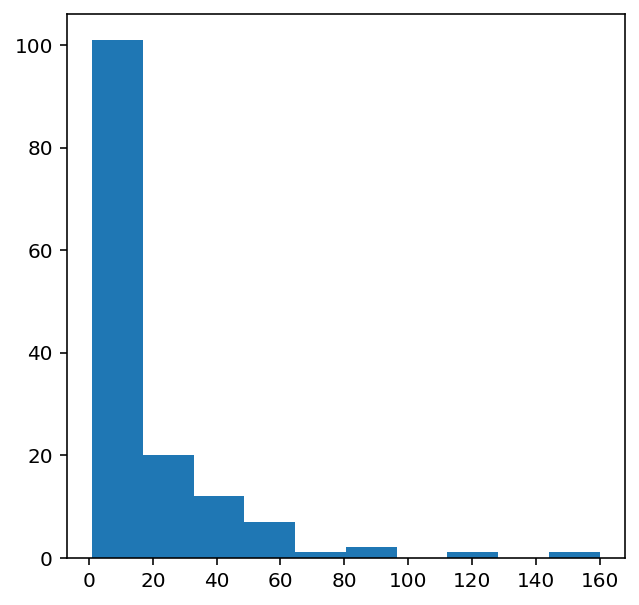

In [10]:
# Notes frequency
freq = dict(Counter(notes_))

no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

## Preparing data

In [11]:
frequent_notes = [note_ for note_, count in freq.items() if count>=frequent_notes_threshold]

# Get the same dataset only with frequent notes
new_music=[]

for notes in notes_array:
    new_music.append([note for note in notes if note in frequent_notes])
    
new_music = np.array(new_music, dtype=object)

In [12]:
inputs = []
outputs = []

for notes_ in new_music:
    for i in range(0, len(notes_) - n_of_timesteps, 1):
        
        inputs.append(notes_[i:i + n_of_timesteps])
        outputs.append(notes_[i + n_of_timesteps])
        
inputs=np.array(inputs)
outputs=np.array(outputs)

In [13]:
unique_inputs = list(set(inputs.ravel()))
input_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_inputs))

input_seq=[]
for input_ in inputs:
    input_seq.append([input_note_to_int[note_] for note_ in input_])
    
input_seq = np.array(input_seq)

In [14]:
unique_outputs = list(set(outputs))
output_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_outputs)) 
output_seq = np.array([output_note_to_int[note_] for note_ in outputs])

## Split data into training and evaluation

In [15]:
input_training, input_validation, output_training, output_validation = train_test_split(input_seq,output_seq,test_size=evaluation_percentage,random_state=0)

## Build model

In [16]:
# LSTM architecture. We will use WaveNet for now
# def lstm():
#   model = Sequential()
#   model.add(LSTM(128,return_sequences=True))
#   model.add(LSTM(128))
#   model.add(Dense(256))
#   model.add(Activation('relu'))
#   model.add(Dense(n_vocab))
#   model.add(Activation('softmax'))
#   model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#   return model

In [17]:
K.clear_session()
model = Sequential()

# Parameters explanation: https://keras.io/api/layers/core_layers/embedding/
model.add(Embedding(len(unique_inputs), output_dimension, input_length=n_of_timesteps,trainable=True)) 

# Parameters explanation: https://keras.io/api/layers/convolution_layers/convolution1d/
model.add(Conv1D(n_of_timesteps*2*2,kernel_size, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(n_of_timesteps*4*2,kernel_size, activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(n_of_timesteps*8*2,kernel_size, activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())

# Parameters explanation: https://keras.io/api/layers/core_layers/dense/
# 256 -> 512
model.add(Dense(512, activation='relu'))
model.add(Dense(len(unique_outputs), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

2021-10-29 10:05:49.270015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1200      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           38528     
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 256)           98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)            0

## Fit model

In [19]:
model_name = 'Gwern_big_model_1024.h5'
epochs = 50
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(input_training),np.array(output_training), batch_size=1024, epochs=epochs, validation_data=(np.array(input_validation),np.array(output_validation)),verbose=1, callbacks=[checkpoint])


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.4147 - val_loss: 2.4110

Epoch 00001: val_loss improved from inf to 2.41103, saving model to Gwern_big_model_1024.h5
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.3755 - val_loss: 2.3860

Epoch 00002: val_loss improved from 2.41103 to 2.38602, saving model to Gwern_big_model_1024.h5
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.3705 - val_loss: 2.3644

Epoch 00003: val_loss improved from 2.38602 to 2.36444, saving model to Gwern_big_model_1024.h5
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.3322 - val_loss: 2.3399

Epoch 00004: val_loss improved from 2.36444 to 2.33991, saving model to Gwern_big_model_1024.h5
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.2828 - val_loss: 2.3106

Epoch 00005: val_loss improved from 2.33991 to 2.31060, saving model to Gwern_big_model_1024.h5
Epoch 6/10
1/1 [============================

In [20]:
model = load_model('Gwern_big_model_1024.h5')

## Generate music!

In [21]:
ind = np.random.randint(0,len(input_validation)-1)
print(ind)
random_music = input_validation[ind]
        
predictions=[]
for i in range(len_of_predictions):

    random_music = random_music.reshape(1,n_of_timesteps)

    prob   = model.predict(random_music)[0]
    
    output_pred = np.argmax(prob, axis=0)
    print(output_pred)
    predictions.append(output_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),output_pred)
    random_music = random_music[1:]
    

26
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [22]:
input_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_inputs)) 
predicted_notes = [input_int_to_note[i] for i in predictions]
print(predicted_notes)

['A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4']


In [23]:
convert_to_midi(predicted_notes, 'gwern_music_small_1024_3.mid')

## Beam search

In [ ]:
import math

def beam_search_generator(starting_data, model, len_of_songs, k):
    n_of_timesteps = len(starting_data[0])
    
    # starting k randomly generated states
    indices = np.random.randint(len(starting_data), size=k)
    # [prediction, random_music, score]
    sequences = [[[], starting_data[index], 0.0] for index in indices]
    # walk over each step in sequence

    for _ in range(len_of_songs):
        assert(len(sequences) == k)
        all_candidates = list()
        all_random_music = [sequence[1] for sequence in sequences]
        all_random_music = np.array(all_random_music).reshape(k, n_of_timesteps)
        prob = model.predict(all_random_music)
        # expand each current candidate
        for i in range(k):
            seq, random_music, score = sequences[i]
            for j in range(len(prob[i])):
                assert(len(random_music) == n_of_timesteps)
                new_random_music = np.insert(random_music,len(random_music),j)
                new_random_music = new_random_music[1:]
                candidate = [seq + [j], new_random_music, score - math.log(prob[i][j])]
                all_candidates.append(candidate)

        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[2])
        # select k best
        sequences = ordered[:k]
    return sequences

In [25]:
# generate music with beam search
result = beam_search_generator(input_validation, model, len_of_predictions, 3)
# print generated songs
for seq in result:
    print(seq)

[[1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.43330583838211]
[[1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.56365799877024]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.75512872036035]


In [26]:
# print best song generated and save midi
predicted_notes = [input_int_to_note[i] for i in seq[0]]
print(predicted_notes)
convert_to_midi(predicted_notes, 'gwern_music_small_1024_beam_search.mid')

['A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3']


## Perplexity

In [9]:
import numpy as np 


def get_predictions(model, song):
    N = len(song)
    predictions = []
    for i in range(1, N):
        # Get the first i notes
        partial_song = song[:i]
        # Pad it with zeroes to get 32 notes
        partial_song_with_padding = np.pad(partial_song, (n_of_timesteps - len(partial_song), 0), 'constant', constant_values=0)
        # Evaluate it
        prob = model.predict(partial_song_with_padding.reshape(1, 32))
        predictions.append(prob[0][-1])
    return predictions

def stable_perplexity(predictions):
    N = len(predictions)
    log_perplexity = 0
    for prob in predictions:
        log_perplexity += np.log(prob)
    return np.exp(-log_perplexity/float(N))

def default_perplexity(predictions):
    N = len(predictions)
    perplexity = 1
    for prob in predictions:
        perplexity*=prob
    return (1/perplexity)**(1/float(N))

def calculate_perplexity(model, song):
    return default_perplexity(get_predictions(model, song))

def calculate_perplexity_stable(model, song):    
    return stable_perplexity(get_predictions(model, song))


In [35]:
### Test perplexities
probs = np.random.random(500)
print(stable_perplexity(probs))
print(default_perplexity(probs))


2.6880580828615903
2.6880580828615908


In [111]:
# Calculate perplexity with random song
index = np.random.randint(len(input_validation))

print(calculate_perplexity(model, input_validation[index]))

1.6449214695973116e-33
